### import libs

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# statistical analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# datadotworld SDK
import datadotworld as ddw
%load_ext watermark

import time

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [8]:
%watermark -v -p pandas,numpy,matplotlib,datadotworld

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

pandas      : 1.5.0
numpy       : 1.23.4
matplotlib  : 3.6.1
datadotworld: 1.8.3



### import data

##### A.mortality data + cancer incidence data

In [18]:
incddf = pd.read_csv('incddf_cleaned.csv')
mortdf = pd.read_csv('mortdf_cleaned.csv')

In [19]:
mortdf['FIPS'] = mortdf.FIPS.apply(lambda x: str(int(x)))\
                            .astype(np.object_)\
                            .str.pad(5, 'left', '0')
incddf['FIPS'] = incddf.FIPS.apply(lambda x: str(int(x)))\
                            .astype(np.object_)\
                            .str.pad(5, 'left', '0')

##### B.poverty data

In [66]:
povdf = pd.read_csv('povdf_cleaned.csv')
povdf['StateFIPS'] = povdf.StateFIPS.astype(np.object_)\
                                    .apply(lambda x: str(x))\
                                    .str.pad(2, 'left', '0')
povdf['CountyFIPS'] = povdf.CountyFIPS.astype(np.object_)\
                                      .apply(lambda x: str(x))\
                                      .str.pad(3, 'left', '0')

##### C.income data

In [68]:
incomedf = pd.read_csv('incomedf_cleaned.csv')
incomedf['StateFIPS'] = incomedf.StateFIPS.astype(np.object_)\
                                .apply(lambda x: str(x))\
                                .str.pad(2, 'left', '0')
incomedf['CountyFIPS'] = incomedf.CountyFIPS.astype(np.object_)\
                                 .apply(lambda x: str(x))\
                                 .str.pad(3, 'left', '0')

##### D. health insurance data

In [70]:
hinsdf = pd.read_csv('hinsdf_cleaned.csv')
hinsdf['StateFIPS'] = hinsdf.StateFIPS.astype(np.object_)\
                                      .apply(lambda x: str(x))\
                                      .str.pad(2, 'left', '0')
hinsdf['CountyFIPS'] = hinsdf.CountyFIPS.astype(np.object_)\
                                        .apply(lambda x: str(x))\
                                        .str.pad(3, 'left', '0')

##### E. population data

In [62]:
popdf = pd.read_csv('CO-EST2015-alldata.csv')

In [63]:
popdf = popdf[['POPESTIMATE2015','STATE','COUNTY']]

In [64]:
state = popdf.STATE.apply(lambda x: str(x))\
                          .str.pad(2, 'left', '0')
county = popdf.COUNTY.apply(lambda x: str(x))\
                            .str.pad(3, 'left', '0')

popdf['FIPS'] = state + county

#### merge dataframes

In [71]:
dfs = [povdf, incomedf, hinsdf, incddf, mortdf]

In [72]:
# create FIPS features
for df in [povdf, incomedf, hinsdf]:
    df['FIPS'] = df.StateFIPS + df.CountyFIPS
    df.drop(['StateFIPS', 'CountyFIPS'], axis=1, inplace=True)

In [78]:
[[i, ii, sum(pd.Series(j.FIPS.unique()).isin(dfs[ii].FIPS))] 
    for i, j in enumerate(dfs) for ii in range(len(dfs))]

[[0, 0, 3142],
 [0, 1, 3142],
 [0, 2, 3142],
 [0, 3, 3134],
 [0, 4, 3134],
 [1, 0, 3142],
 [1, 1, 3142],
 [1, 2, 3142],
 [1, 3, 3134],
 [1, 4, 3134],
 [2, 0, 3142],
 [2, 1, 3142],
 [2, 2, 3142],
 [2, 3, 3134],
 [2, 4, 3134],
 [3, 0, 3134],
 [3, 1, 3134],
 [3, 2, 3134],
 [3, 3, 3141],
 [3, 4, 3141],
 [4, 0, 3134],
 [4, 1, 3134],
 [4, 2, 3134],
 [4, 3, 3141],
 [4, 4, 3141]]

In [79]:
for i in dfs:
    print(len(i.FIPS.unique()))

3142
3142
3142
3141
3141


In [80]:
dfs = [povdf, incomedf, hinsdf, incddf, mortdf] # our 5 dataframes to merge
for i, j in enumerate(dfs):
    lens = []
    for fips in j.FIPS.values:
        lens.append(len(fips))
    print(pd.Series(lens).value_counts(), '\n', '-'*10)    

5    3142
dtype: int64 
 ----------
5    3142
dtype: int64 
 ----------
5    3142
dtype: int64 
 ----------
5    3141
dtype: int64 
 ----------
5    3141
dtype: int64 
 ----------


In [81]:
for i, j in enumerate(dfs):
    if i == 0:
        fulldf = j.copy()
    else:
        fulldf = fulldf.merge(j, how='inner', on='FIPS')

In [84]:
fulldf.drop(columns=['State_y'],inplace=True)

In [85]:
fulldf.columns #'StateFIPS','CountyFIPS'
fulldf.rename(columns={'State_x':'State'},inplace=True)

### EDA & data cleaning (Exploratory Data Analysis) - 5 cols need to be converted to numeric-> Med_Income, Incidence_Rate, Avg_Ann_Incidence, Mortality_Rate, Avg_Ann_Deaths; 1 col need to be coverted to dummy var -> RecentTrend

In [95]:
fulldf.drop(['Med_Income_White', 'Med_Income_Black', 'Med_Income_Nat_Am',
             'Med_Income_Asian', 'Hispanic'], axis=1, inplace=True)

In [96]:
data_dict = pd.DataFrame(fulldf.columns.values, index=range(len(fulldf.columns)), columns=['Feature'])

data_dict['Definition'] = ['','','Both male and female reported below poverty line (Raw)', 
                           'Males below poverty (Raw)', 'Females below poverty (Raw)', 'State + County FIPS (Raw)',
                           'Med_Income all enthnicities (Raw)', 'Males with health insurance (Raw)',
                           'Males without health insurance (Raw)', 'Females with health insurance (Raw)',
                           'Females without health insurance (Raw)', 'Males and Femaes with health ins. (Raw)',
                           'Males an Females without health ins (Raw)', 'Lung cancer incidence rate (per 100,000)',
                           'Average lung cancer incidence rate (Raw)', 'Recent trend (incidence)', 
                           'Lung cancer mortality rate (per 100,000)', 'Average lung cancer mortalities (Raw)']

data_dict['Notes'] = ''
data_dict.loc[[13,16], 'Notes'] = "'*' = fewer that 16 reported cases"

data_dict

,Feature,Definition,Notes
0,State,,
1,AreaName,,
2,All_Poverty,Both male and female reported below poverty li...,
3,M_Poverty,Males below poverty (Raw),
4,F_Poverty,Females below poverty (Raw),
5,FIPS,State + County FIPS (Raw),
6,Med_Income,Med_Income all enthnicities (Raw),
7,M_With,Males with health insurance (Raw),
8,M_Without,Males without health insurance (Raw),
9,F_With,Females with health insurance (Raw),


In [97]:
# drop records with mortality rate = *
fulldf = fulldf[fulldf.Mortality_Rate != '*']

##### 1.Mortality_Rate and Med_Income

In [98]:
fulldf['Mortality_Rate'] = pd.to_numeric(fulldf.Mortality_Rate)
fulldf['Med_Income'] = pd.to_numeric(fulldf.Med_Income)

##### 2. Incidence_Rate (leave it alone for now) redundant with Avg_Ann_Incidence and Avg_Ann_Deaths

In [99]:
values = []
for _, j in enumerate(fulldf.Incidence_Rate):
    try:
        pd.to_numeric(j)
    except:
        values.append(j)
        
pd.Series(values).value_counts()[:10]

_         151
__         12
*           5
71.1 #      2
68.2 #      2
73.6 #      2
48.6 #      1
78.6 #      1
75.3 #      1
63.6 #      1
dtype: int64

##### 3. RecentTrend -> dummy var

In [100]:
fulldf.rename(columns={'Recent Trend':'RecentTrend'}, inplace=True)
fulldf.replace({'RecentTrend' : {'*':'stable'}}, inplace=True)

In [101]:
values = []
for _, j in enumerate(fulldf.RecentTrend):
    try:
        pd.to_numeric(j)
    except:
        values.append(j)
        
pd.Series(values).value_counts()[:10]

stable     2410
falling     197
_           151
rising       39
__           12
dtype: int64

In [102]:
# function to do boolean check and return 1 or 0
def f(x, term):
    if x == term:
        return 1
    else:
        return 0

# create new features using the apply method with the 'f' function we defined above
fulldf['Rising'] = fulldf.RecentTrend.apply(lambda x: f(x, term='rising'))
fulldf['Falling'] = fulldf.RecentTrend.apply(lambda x: f(x, term='falling'))

In [103]:
fulldf = fulldf.merge(popdf[['FIPS', 'POPESTIMATE2015']], on='FIPS', how='inner')

In [104]:
y = pd.to_numeric(fulldf.Mortality_Rate).values
X = fulldf.loc[:,['All_Poverty', 'M_Poverty', 'F_Poverty', 'Med_Income',
            'M_With', 'M_Without', 'F_With', 'F_Without', 'All_With',
            'All_Without', 'Incidence_Rate', 'Falling', 'Rising',
            'POPESTIMATE2015']]

In [105]:
# The "errors='coerce'" argument to the pd.to_numeric method, tells pandas to replace any value that can't be converted to a float with 'nan'.
X['Incidence_Rate'] = pd.to_numeric(X.Incidence_Rate, errors='coerce')
X['Incidence_Rate'] = X.Incidence_Rate.fillna(X.Incidence_Rate.median())

###### (!)note: In this case we should probably convert our numeric data to per capita. Our target variable, mortality rate, is measured per 100,000 population. By normalizing each variable by 100,000 population, we can more easily assess how they correlate with each other. In case we want to account for the influence of population in our model, we can also retain the population feature.

In [106]:
for col in ['All_Poverty', 'M_Poverty', 'F_Poverty', 'M_With',
            'M_Without', 'F_With', 'F_Without', 'All_With', 'All_Without']:
       
    X[col + "_PC"] = X[col] / X.POPESTIMATE2015 * 10**5

### Visual Exploratory Analysis

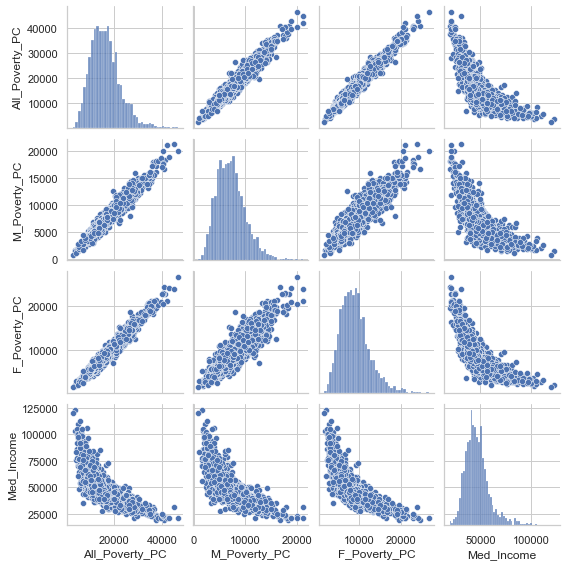

In [107]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(X[['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']], size=2)
plt.show()

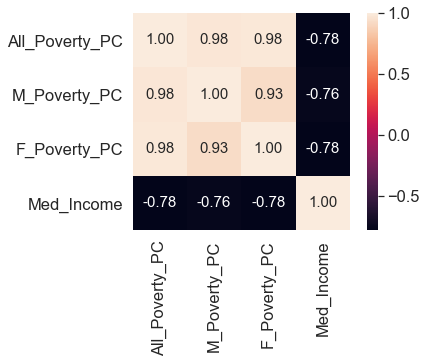

In [108]:
cols = ['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']
cm = np.corrcoef(X[['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15},
                 yticklabels=cols, xticklabels=cols)
plt.show()


In [109]:
X.drop(['M_Poverty_PC', 'F_Poverty_PC'], axis=1, inplace=True)
X.drop(['M_With_PC', 'F_With_PC'], axis=1, inplace=True)
X.drop(['M_Without_PC', 'F_Without_PC'], axis=1, inplace=True)

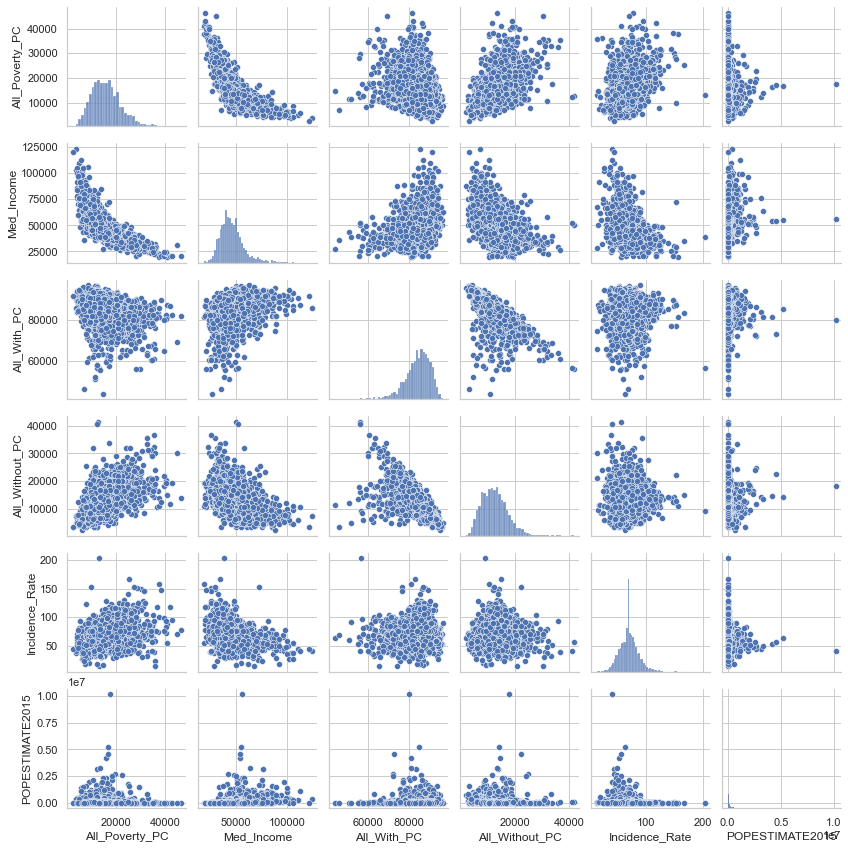

In [110]:
cols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
                'Incidence_Rate', 'POPESTIMATE2015']
sns.set(style='whitegrid', context='notebook')
sns.pairplot(X[cols], size=2)
plt.show()

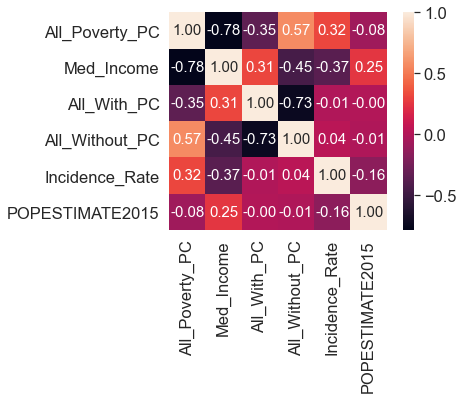

In [111]:
cm = np.corrcoef(X[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15},
                 yticklabels=cols, xticklabels=cols)
plt.show()

### Linear Regression Model

In [112]:
cols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC',  'All_Without_PC',
        'Incidence_Rate', 'POPESTIMATE2015', 'Falling', 'Rising', 'All_Poverty',
        'All_With', 'All_Without']
X = X[cols]
X['Constant'] = 1
X.reset_index(drop=True, inplace=True)

In [113]:
# Fit linear regression model
lr = sm.OLS(y, X, hasconst=True)
result = lr.fit()

In [114]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     718.0
Date:                Sun, 15 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:06:07   Log-Likelihood:                -9523.1
No. Observations:                2809   AIC:                         1.907e+04
Df Residuals:                    2797   BIC:                         1.914e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
All_Poverty_PC   9.517e-05   4.12e-05      2.308      0.021    1.43e-05       0.000
Med_Income         -0.0001   2.04e-05     -4.982      0.000      -0.000   -6.17e-05
All_With_PC      9.094e-06   3.33e-05      0.273      0.785   -5.61e-05    7.43e-05
All_Without_PC      0.0002   5.04e-05      4.310      0.000       0.000       0.000
Incidence_Rate      0.6517      0.009     73.756      0.000       0.634       0.669
POPESTIMATE2015 -4.224e-05   2.69e-05     -1.573      0.116   -9.49e-05    1.04e-05
Falling             1.2490      0.562      2.224      0.026       0.148       2.350
Rising             -1.0811      1.163     -0.929      0.353      -3.362       1.200
All_Poverty      -2.81e-05    1.3e-05     -2.167      0.030   -5.35e-05   -2.67e-06
All_With         4.428e-05   2.77e-05      1.600      0.110   -9.99e-06    9.86e-05
All_Without      5.714e-05   3.24e-05      1.762      0.078   -6.44e-06       0.000
Constant            7.2748      3.482      2.089      0.037       0.448      14.102
==============================================================================
Omnibus:                      306.600   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2334.415
Skew:                          -0.204   Prob(JB):                         0.00
Kurtosis:                       7.447   Cond. No.                     1.23e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Multicollinearity

In [115]:
pd.DataFrame([[var, variance_inflation_factor(X.values, X.columns.get_loc(var))] for var in X.columns],
                   index=range(X.shape[1]), columns=['Variable', 'VIF'])

,Variable,VIF
0,All_Poverty_PC,3.454206
1,Med_Income,3.490674
2,All_With_PC,2.433937
3,All_Without_PC,3.180459
4,Incidence_Rate,1.225081
5,POPESTIMATE2015,4692.901021
6,Falling,1.116247
7,Rising,1.005324
8,All_Poverty,30.052522
9,All_With,3342.491590


In [116]:
# update cols
vcols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
       'Incidence_Rate', 'Falling', 'Rising', 'Constant']

In [117]:
Xvcols = X[vcols].reset_index(drop=True)
pd.DataFrame([[var, variance_inflation_factor(Xvcols.values, Xvcols.columns.get_loc(var))] for var in vcols],
                   index=range(len(vcols)), columns=['Variable', 'VIF'])

,Variable,VIF
0,All_Poverty_PC,3.174942
1,Med_Income,2.798807
2,All_With_PC,2.217165
3,All_Without_PC,2.923831
4,Incidence_Rate,1.207559
5,Falling,1.035371
6,Rising,1.004835
7,Constant,606.236305


In [118]:
vcols = ['All_Poverty_PC', 'Med_Income', 'All_Without_PC',
       'Incidence_Rate', 'Falling', 'POPESTIMATE2015', 'Constant']
Xvcols = X[vcols].reset_index(drop=True)
lr = sm.OLS(y, Xvcols, hasconst=True)
result = lr.fit()

In [119]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     1314.
Date:                Sun, 15 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:06:19   Log-Likelihood:                -9526.6
No. Observations:                2809   AIC:                         1.907e+04
Df Residuals:                    2802   BIC:                         1.911e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
All_Poverty_PC   8.805e-05   3.97e-05      2.219      0.027    1.03e-05       0.000
Med_Income      -9.367e-05   1.89e-05     -4.954      0.000      -0.000   -5.66e-05
All_Without_PC      0.0002    3.5e-05      6.147      0.000       0.000       0.000
Incidence_Rate      0.6538      0.009     74.362      0.000       0.637       0.671
Falling             1.2889      0.560      2.303      0.021       0.192       2.386
POPESTIMATE2015 -1.773e-06    4.3e-07     -4.123      0.000   -2.62e-06    -9.3e-07
Constant            7.6227      1.602      4.758      0.000       4.481      10.764
==============================================================================
Omnibus:                      305.716   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2327.137
Skew:                          -0.201   Prob(JB):                         0.00
Kurtosis:                       7.441   Cond. No.                     4.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Are residuals normally distributed?

In [120]:
import scipy.stats as stats

In [121]:
result.resid

0        3.409250
1        6.971811
2       11.883555
3        8.295383
4        0.866162
          ...    
2804    -2.660633
2805     8.961616
2806    -5.132933
2807    -2.443374
2808     8.488595
Length: 2809, dtype: float64

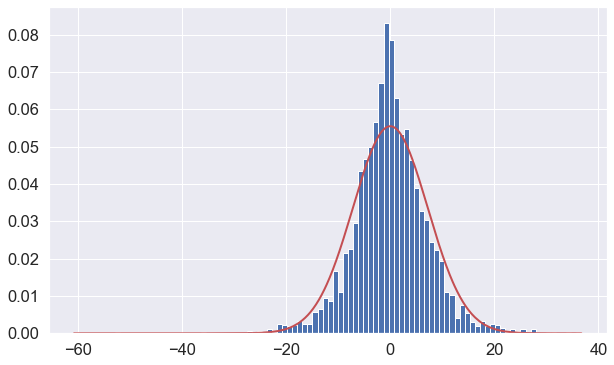

In [122]:
# histogram superimposed by normal curve
plt.figure(figsize=(10,6))
mu = np.mean(result.resid)
sigma = np.std(result.resid)
pdf = stats.norm.pdf(sorted(result.resid), mu, sigma)
plt.hist(result.resid, bins=100,density=True)
plt.plot(sorted(result.resid), pdf, color='r', linewidth=2)
plt.show()

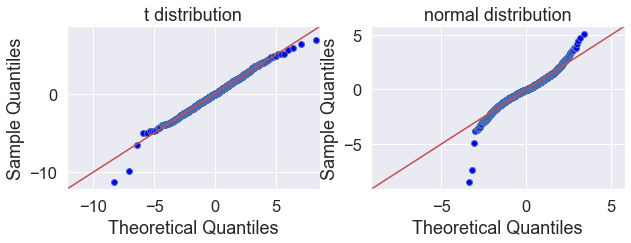

In [123]:
# QQplot
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,3))
sm.qqplot(result.resid, stats.t, fit=True, line='45', ax = ax1)
ax1.set_title("t distribution")
sm.qqplot(result.resid, stats.norm, fit=True, line='45', ax=ax2)
ax2.set_title("normal distribution")
plt.show()

#### Heteroscedasticity

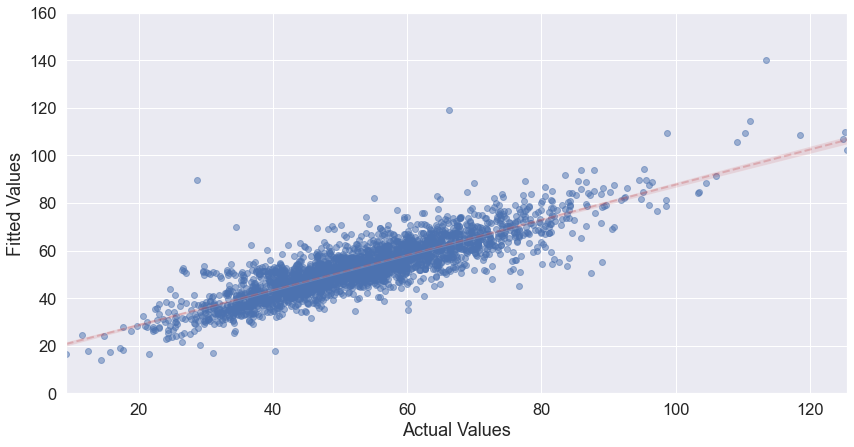

Pearson R:  (0.8589643646814925, 0.0)


In [124]:
# plot predicted vs actual
plt.figure(figsize=(14,7))
sns.regplot(y, result.fittedvalues, line_kws={'color':'r', 'alpha':0.3, 
                                              'linestyle':'--', 'linewidth':2}, 
            scatter_kws={'alpha':0.5})
plt.ylim(0,160)
plt.xlabel('Actual Values')
plt.ylabel('Fitted Values')
plt.show()
print("Pearson R: ", stats.pearsonr(result.fittedvalues, y))
# Consistent with our reported R^2 value, we now visualize the 
# strong correlation between actual and predicted values.

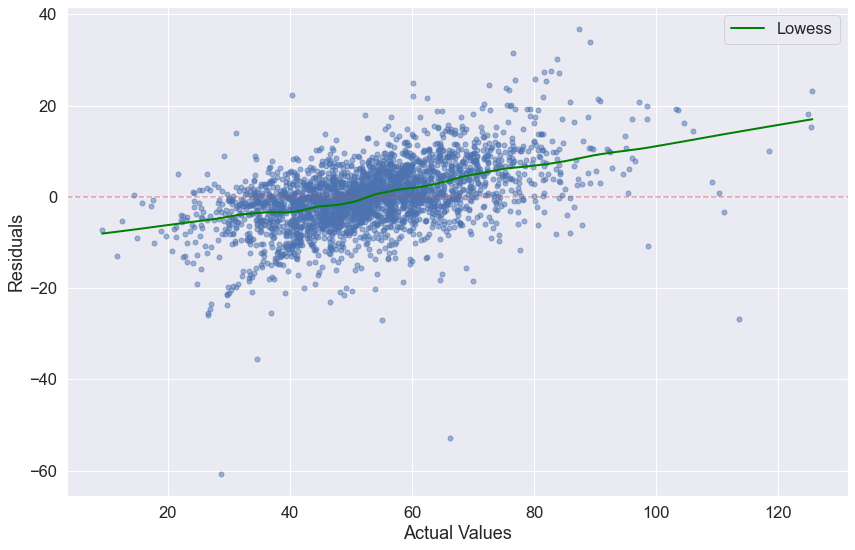

Pearson R: (0.5120353700745511, 1.36862211680211e-187)


In [125]:
# plot actual values versus residuals
from statsmodels.nonparametric.smoothers_lowess import lowess
ys = lowess(result.resid.values, y, frac=0.2)
ys = pd.DataFrame(ys, index=range(len(ys)), columns=['a', 'b'])
ys = ys.sort_values(by='a')

fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(y, result.resid, alpha=0.5, s=25)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")

plt.plot(ys.a, ys.b, c='green', linewidth=2, label="Lowess")
plt.legend()
plt.show()
print("Pearson R:", stats.pearsonr(y, result.resid))

# This chart suggests that the model tends to somewhat overshoot lower values, and undershoot higher ones.

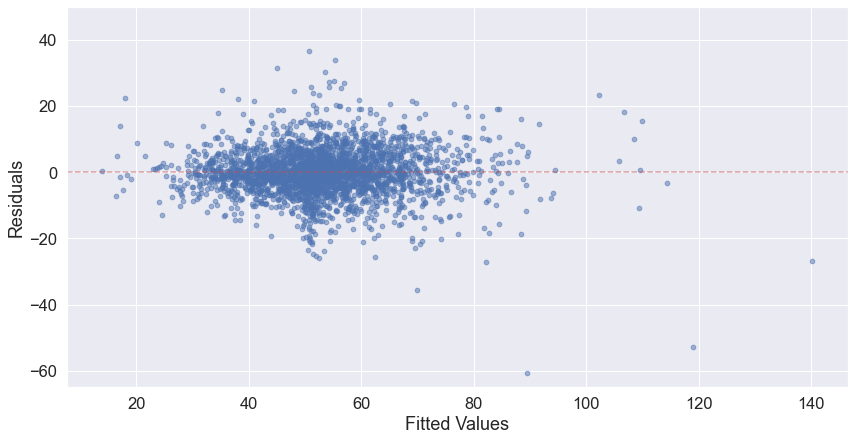

In [126]:
# plot actual values versus residuals
plt.figure(figsize=(14,7))
plt.scatter(y=result.resid, x=result.fittedvalues, alpha=0.5, s=22)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.ylim(-65, 50)
plt.show()
# The plot of residuals versus fitted values shows that the residuals are fairly 
# symmetric relative to the fitted values.